In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from string import punctuation
from sklearn import tree
import matplotlib.pyplot as plt

from sklearn. model_selection import train_test_split 
from sklearn.utils import resample,shuffle

Change the folder either to `instagram_data/` or to `twitter_data/`

In [17]:
folder  = 'twitter_data/' #twitter_data/ or instagram_data/

In [18]:
data = pd.read_csv(folder +'posts_processed.csv')
green = pd.read_csv(folder +'green_posts_processed.csv')

/var/folders/pv/j2wxhdx50y5fbwqrc2yxqwf00000gn/T/ipykernel_68684/1928277876.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(folder +'posts_processed.csv')


In [19]:
word_list_en = ['sustainab','climate','green','environment','ecofriendly','eco-friendly','biodegra','renewable','netzero','greenbuild','decarbon','recycl', 'pollut','zero waste','wind energy','co2 neutral','co2-neutral','solar', 'emissions','global warming','fair trade']
word_list_de = ['nachhaltig', 'klima','umwelt','ökolog','erneuerbar','bio ','natur ']

word_list_en_recall = word_list_en + ['co2']
word_list_de_recall = word_list_de + ['biologisch']
word_list_high_recall = word_list_de + word_list_en

word_list_en_precision = [ elem for elem in word_list_en if not elem in ['green', 'climate', 'environment']]  
word_list_de_precision = [ elem for elem in word_list_de if not elem in ['klima','natur ']]  
word_list_high_precision = word_list_de + word_list_en

regex_query_recall = ('|').join(word_list_high_recall)
regex_query_precision = ('|').join(word_list_high_precision)

### Prediction

In [20]:
df_1 = pd.read_csv('twitter_data/test_sets/test_set.csv')
df_1 = df_1[:1000]
df_1 = df_1[['Tweets','gold_label_sustainability','general','green']]
df_1['green'] = df_1['green'] == 'TRUE'

df_1['green_recall'] = df_1['Tweets'].str.contains(regex_query_recall, na=False, case=False,regex=True)
df_1['green_precision'] = df_1['Tweets'].str.contains(regex_query_precision, na=False, case=False,regex=True)

df_1.reset_index(inplace=True, drop=True)
for column in ['gold_label_sustainability', 'green', 'general', 'green_recall', 'green_precision']:
    df_1[column] = df_1[column].apply(lambda x: 1 if x == True else 0 )
df_1

,Tweets,gold_label_sustainability,general,green,green_recall,green_precision
0,RT @SustainBrands: WEBINAR: Gain insights into...,1,1,1,1,1
1,RT @AmChemistry: ACC's Steve Russell speaks wi...,1,1,1,1,1
2,Reliably integrate renewable energy sources in...,1,1,1,1,1
3,"Ja, es gibt sie wirklich, die Deutsche Schneep...",0,0,0,0,0
4,Looks like it might be time to get our groove ...,0,0,0,0,0
...,...,...,...,...,...,...
995,Ready or not – Digital transformation is comin...,0,0,0,0,0
996,Digital twins are the user interfaces of the f...,0,0,0,0,0
997,"At our lastest tech for-event, @ShashankSamala...",1,1,1,1,1
998,.@DHLexpress is investing in e-cargo planes bu...,1,0,1,0,0


In [21]:
df_2 = pd.read_csv('twitter_data/test_sets/test_set_2.csv')
df_2 = df_2[:311]
df_2 = df_2[['Tweets','gold_label_sustainability','general','green']]
df_2.reset_index(inplace=True, drop=True)

df_2['green_recall'] = df_2['Tweets'].str.contains(regex_query_recall, na=False, case=False,regex=True)
df_2['green_precision'] = df_2['Tweets'].str.contains(regex_query_precision, na=False, case=False,regex=True)

for column in ['gold_label_sustainability', 'green', 'general', 'green_recall', 'green_precision']:
    df_2[column] = df_2[column].apply(lambda x: 1 if x == True else 0 )
df_2

,Tweets,gold_label_sustainability,general,green,green_recall,green_precision
0,Heute schon en:formiert? Neu im #enformerblog:...,1,1,1,1,1
1,"Walter Leitner, professor at the @RWTH Aachen ...",1,1,1,1,1
2,Greece’s 🇬🇷 #decarbonization journey is not an...,1,1,1,1,1
3,#DeutschePostDHL mit umweltfreundlichem Versan...,1,1,1,1,1
4,Exploring the role of transport in a world bel...,1,1,1,1,1
...,...,...,...,...,...,...
306,#Greece: rapprochement in the debate over debt...,0,0,1,1,1
307,“More is better” is a relic of the past – we a...,1,1,1,1,1
308,And... 𝗜𝗧's 𝗔👌🏻1st flight for @ITAAirways' #A3...,1,0,1,1,1
309,"As part of HRH The Prince of Wales’ @TheSMI, t...",1,1,1,1,1


In [22]:
merged = pd.concat([df_1, df_2])
merged.reset_index(inplace=True, drop=True)
merged

,Tweets,gold_label_sustainability,general,green,green_recall,green_precision
0,RT @SustainBrands: WEBINAR: Gain insights into...,1,1,1,1,1
1,RT @AmChemistry: ACC's Steve Russell speaks wi...,1,1,1,1,1
2,Reliably integrate renewable energy sources in...,1,1,1,1,1
3,"Ja, es gibt sie wirklich, die Deutsche Schneep...",0,0,0,0,0
4,Looks like it might be time to get our groove ...,0,0,0,0,0
...,...,...,...,...,...,...
1306,#Greece: rapprochement in the debate over debt...,0,0,1,1,1
1307,“More is better” is a relic of the past – we a...,1,1,1,1,1
1308,And... 𝗜𝗧's 𝗔👌🏻1st flight for @ITAAirways' #A3...,1,0,1,1,1
1309,"As part of HRH The Prince of Wales’ @TheSMI, t...",1,1,1,1,1


In [23]:
general_df = merged[merged['gold_label_sustainability']==1]
general_df.reset_index(inplace=True, drop=True)
general_df

,Tweets,gold_label_sustainability,general,green,green_recall,green_precision
0,RT @SustainBrands: WEBINAR: Gain insights into...,1,1,1,1,1
1,RT @AmChemistry: ACC's Steve Russell speaks wi...,1,1,1,1,1
2,Reliably integrate renewable energy sources in...,1,1,1,1,1
3,RT @Siemens_Aus: Did you know that Siemens is ...,1,1,1,1,1
4,RT @PghBizTimes: .@CovestroGroup and @penguins...,1,1,1,1,1
...,...,...,...,...,...,...
502,RT @SiemensII #Solar panels &amp; #Siemens mi...,1,0,1,1,1
503,“More is better” is a relic of the past – we a...,1,1,1,1,1
504,And... 𝗜𝗧's 𝗔👌🏻1st flight for @ITAAirways' #A3...,1,0,1,1,1
505,"As part of HRH The Prince of Wales’ @TheSMI, t...",1,1,1,1,1


### Quality measures and confusion matrix for the "green" query 

Metrics for the first test set (test set with 1000 Tweets):

In [27]:
green_label = 'green_precision'
print("Accuracy:", round(100* accuracy_score(df_1['gold_label_sustainability'], df_1[green_label]),2),"%")
print("Precision:", round(100* precision_score(df_1['gold_label_sustainability'], df_1[green_label]),2),"%")
print("Recall:", round(100* recall_score(df_1['gold_label_sustainability'], df_1[green_label]),2),"%")
print("F1-Score:", round(100* f1_score(df_1['gold_label_sustainability'], df_1[green_label]),2),"%")

Accuracy: 92.7 %
Precision: 83.46 %
Recall: 87.85 %
F1-Score: 85.6 %


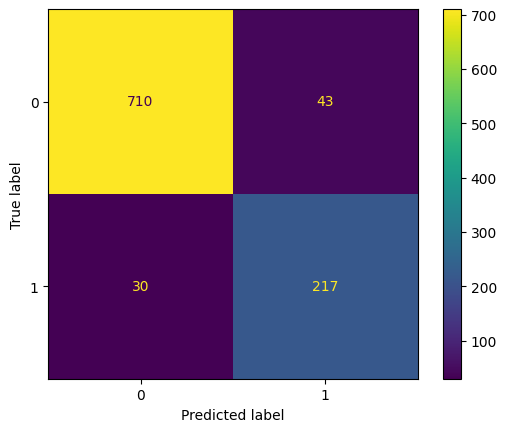

In [28]:
cm = confusion_matrix(df_1['gold_label_sustainability'], df_1[green_label])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Metrics for the large test set (test set with 1311 Tweets)

In [29]:
print("Accuracy:", round(100* accuracy_score(merged['gold_label_sustainability'], merged[green_label]),2),"%")
print("Precision:", round(100* precision_score(merged['gold_label_sustainability'], merged[green_label]),2),"%")
print("Recall:", round(100* recall_score(merged['gold_label_sustainability'], merged[green_label]),2),"%")
print("F1-Score:", round(100* f1_score(merged['gold_label_sustainability'], merged[green_label]),2),"%")

Accuracy: 91.0 %
Precision: 85.56 %
Recall: 92.31 %
F1-Score: 88.8 %


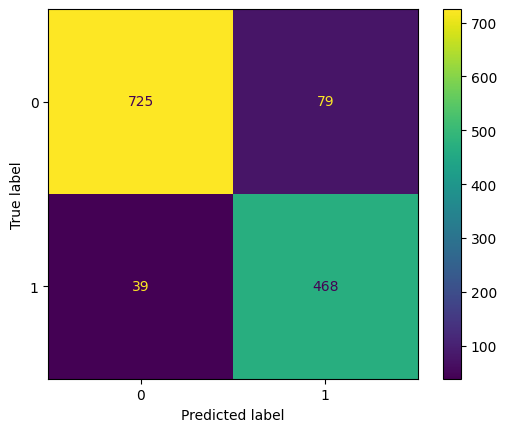

In [30]:
cm = confusion_matrix(merged['gold_label_sustainability'], merged[green_label])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [31]:
general_df

,Tweets,gold_label_sustainability,general,green,green_recall,green_precision
0,RT @SustainBrands: WEBINAR: Gain insights into...,1,1,1,1,1
1,RT @AmChemistry: ACC's Steve Russell speaks wi...,1,1,1,1,1
2,Reliably integrate renewable energy sources in...,1,1,1,1,1
3,RT @Siemens_Aus: Did you know that Siemens is ...,1,1,1,1,1
4,RT @PghBizTimes: .@CovestroGroup and @penguins...,1,1,1,1,1
...,...,...,...,...,...,...
502,RT @SiemensII #Solar panels &amp; #Siemens mi...,1,0,1,1,1
503,“More is better” is a relic of the past – we a...,1,1,1,1,1
504,And... 𝗜𝗧's 𝗔👌🏻1st flight for @ITAAirways' #A3...,1,0,1,1,1
505,"As part of HRH The Prince of Wales’ @TheSMI, t...",1,1,1,1,1


### Machine Learning Approaches

In the following, different machine learing algorithms are presented to either predict whether a post is sustainable or whether a sustainable post has a specific claim or not

set df to `merged` for predicting sustainability or `general_df` for predicting general claims

In [207]:
df = general_df 
gold_label = 'general'

In [208]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/theakramer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/theakramer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/theakramer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [209]:
def preprocess(df):
    df['Tweets'] = df['Tweets'].astype(str)
    df['Tweets'] = [entry.lower() for entry in df['Tweets']]
    df['Tweets']= [word_tokenize(entry) for entry in df['Tweets']]
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    for index,entry in enumerate(df['Tweets']):
        Final_words = []
        word_Lemmatized = WordNetLemmatizer()
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word not in stopwords.words('german') and not any(p in word for p in punctuation):# and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text_final'
        df.loc[index,'text_final'] = str(Final_words)
    return df

In [210]:
df = preprocess(df)
greens = df[df[gold_label]==False]
spam_upsample = resample(greens, replace=True,n_samples= df.shape[0] - greens.shape[0], random_state=42)
df_resampled = pd.concat([df[df[gold_label]==True], spam_upsample])
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df_resampled['text_final'],df_resampled[gold_label],test_size=0.3)
#Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['text_final'],df[gold_label],stratify=df[gold_label], test_size=0.3)

/var/folders/pv/j2wxhdx50y5fbwqrc2yxqwf00000gn/T/ipykernel_61833/2454451067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweets'] = df['Tweets'].astype(str)
/var/folders/pv/j2wxhdx50y5fbwqrc2yxqwf00000gn/T/ipykernel_61833/2454451067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweets'] = [entry.lower() for entry in df['Tweets']]
/var/folders/pv/j2wxhdx50y5fbwqrc2yxqwf00000gn/T/ipykernel_61833/2454451067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [211]:
def vectorize_data(df, X):
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(df['text_final'])
    return Tfidf_vect.transform(X)

def encode_labels(Y):
    Encoder = LabelEncoder()
    return Encoder.fit_transform(Y)

Train_X_Tfidf = vectorize_data(df, Train_X)
Train_Y = encode_labels(Train_Y)
Test_X_Tfidf = vectorize_data(df, Test_X)
Test_Y = encode_labels(Test_Y)

Naive Bayes Accuracy Score ->  84.34782608695653
Naive Bayes Recall Score ->  77.98165137614679
Naive Bayes Precision Score ->  87.62886597938144
Naive Bayes F1 Score ->  82.52427184466019


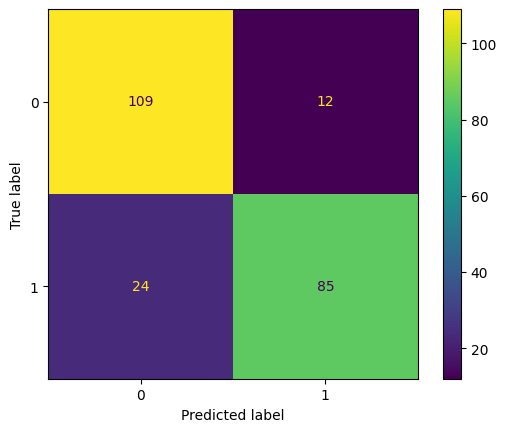

In [212]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB(
    #class_prior = [0.3,0.7]
    )
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(Test_Y, predictions_NB)*100)
print("Naive Bayes Recall Score -> ",recall_score(Test_Y, predictions_NB)*100)
print("Naive Bayes Precision Score -> ",precision_score(Test_Y, predictions_NB)*100)
print("Naive Bayes F1 Score -> ",f1_score(Test_Y, predictions_NB)*100)
cm = confusion_matrix(Test_Y, predictions_NB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

SVM Accuracy Score ->  47.391304347826086
SVM Recall Score ->  100.0
SVM Precision Score ->  47.161572052401745
SVM F1 Score ->  64.09495548961425


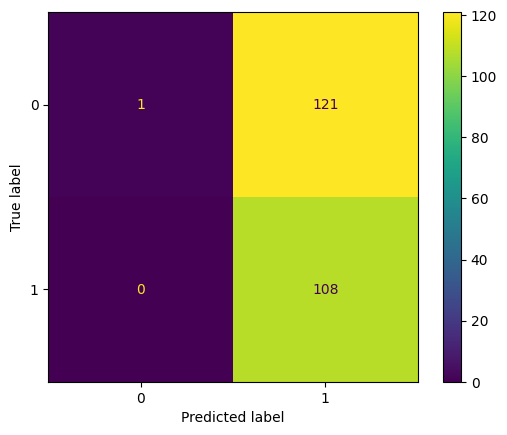

In [192]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(Test_Y, predictions_SVM)*100)
print("SVM Recall Score -> ",recall_score(Test_Y, predictions_SVM)*100)
print("SVM Precision Score -> ",precision_score(Test_Y, predictions_SVM)*100)
print("SVM F1 Score -> ",f1_score(Test_Y, predictions_SVM)*100)
cm = confusion_matrix(Test_Y, predictions_SVM,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Decision Tree Accuracy Score ->  81.30434782608695
Decision Tree Recall Score ->  68.14159292035397
Decision Tree Precision Score ->  91.66666666666666
Decision Tree F1 Score ->  78.1725888324873


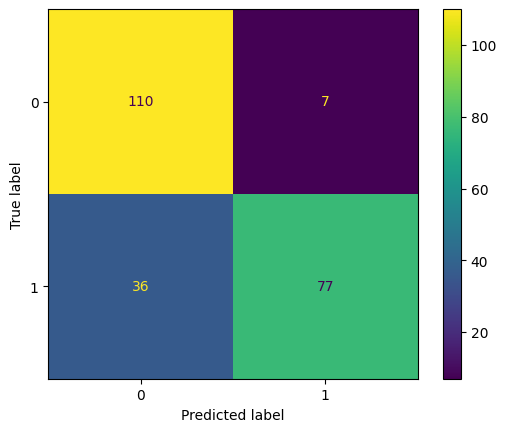

In [180]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
clf = tree.DecisionTreeClassifier()
clf.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_DT = clf.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Decision Tree Accuracy Score -> ",accuracy_score(Test_Y, predictions_DT )*100)
print("Decision Tree Recall Score -> ",recall_score(Test_Y, predictions_DT )*100)
print("Decision Tree Precision Score -> ",precision_score(Test_Y, predictions_DT )*100)
print("Decision Tree F1 Score -> ",f1_score(Test_Y, predictions_DT )*100)
cm = confusion_matrix(Test_Y, predictions_DT ,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [213]:
dfr = pd.DataFrame(Test_X)
dfr = dfr.reset_index(level=0)
dfr['predictions_svm'] = pd.DataFrame(predictions_SVM)
dfr['correct'] = pd.DataFrame(Test_Y)
dfr.to_csv('predictions0802.csv', header=True, index=False, columns=list(dfr.axes[1]))


In [216]:
preprocessed = preprocess(green)
final_data = vectorize_data(preprocessed, preprocessed['text_final'])

In [ ]:
predictions_final = SVM.predict(final_data)
print(predictions_final)

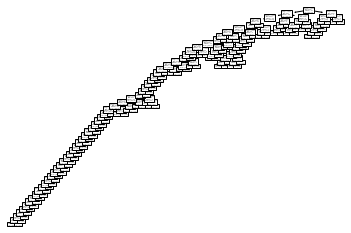

In [105]:
from sklearn import tree
tree.plot_tree(clf)
plt.savefig('decision_tree.pdf') 